Constants

In [ ]:
TEST_DAYS     = 252       # How long the final forecast will be
WINDOW        = 63        # 1 month of history = 21; 1 year of history = 252
HORIZON       = 21        # Forcasting horizon split size

size_layer    = 64        # hidden_size
num_layers    = 2         # number of layers
dropout_rate  = 0.15      # 0.1 to 0.3
epoch         = 400       # training iterations
learning_rate = 3e-3      # 3e-3 to 1e-4
weight_decay  = 1e-5      # 1e-2 to 1e-5 
min_lr        = 1e-8      # lr will reduce to this value slowly
batch_size    = 128       # based on Vram
max_norm      = 5         # 1 (potentially slow training), 5 or 10 (potentially instable)

Data Loading

In [2]:
import torch
from sklearn.preprocessing import StandardScaler
from data_loader import create_df, make_windows

features = ["Open", "High", "Low", "Close"]
df = create_df("MSFT")

data = df[features].values
data_len = len(data)

# index where test period starts (raw data index)
test_start = data_len - (TEST_DAYS + WINDOW)

train_raw = data[:test_start]
test_raw  = data[test_start:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled = scaler.transform(test_raw)

X_train, Y_train = make_windows(train_scaled, WINDOW, HORIZON)
X_test,  Y_test  = make_windows(test_scaled,  WINDOW, HORIZON)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32)

print(len(X_train_t))
print(len(X_train_t[0]))
print(len(X_test_t))
print(len(X_test_t[0]))
print()
print(len(Y_train_t))
print(len(Y_train_t[0]))
print(len(Y_test_t))
print(len(Y_test_t[0]))



2117
63
232
63

2117
21
232
21


Model Training

In [3]:
import LSTM_model as M
from training_helpers import train_model

input_size = X_train_t.shape[2]
output_size = X_train_t.shape[2]

model = M.LSTMForecaster(
    input_size=input_size,
    hidden_size=size_layer,
    num_layers=num_layers,
    horizon=HORIZON,
    output_size=output_size,
    dropout=dropout_rate,
)

# Train
train_model(
    model,
    X_train_t,
    Y_train_t,
    epochs=epoch,
    lr=learning_rate,
    weight_decay=weight_decay,
    min_lr=min_lr,
    batch_size=batch_size,
    max_norm=max_norm
)

Epoch 1/300 | Total Loss: 15.265182 | Avg Loss: 0.897952 | LR: 3.00e-03
Epoch 2/300 | Total Loss: 5.393504 | Avg Loss: 0.317265 | LR: 3.00e-03
Epoch 3/300 | Total Loss: 3.560671 | Avg Loss: 0.209451 | LR: 3.00e-03
Epoch 4/300 | Total Loss: 2.023033 | Avg Loss: 0.119002 | LR: 3.00e-03
Epoch 5/300 | Total Loss: 2.228995 | Avg Loss: 0.131117 | LR: 3.00e-03
Epoch 6/300 | Total Loss: 1.500980 | Avg Loss: 0.088293 | LR: 3.00e-03
Epoch 7/300 | Total Loss: 1.741396 | Avg Loss: 0.102435 | LR: 3.00e-03
Epoch 8/300 | Total Loss: 2.603913 | Avg Loss: 0.153171 | LR: 3.00e-03
Epoch 9/300 | Total Loss: 3.074698 | Avg Loss: 0.180865 | LR: 3.00e-03
Epoch 10/300 | Total Loss: 3.563905 | Avg Loss: 0.209641 | LR: 3.00e-03
Epoch 11/300 | Total Loss: 1.091163 | Avg Loss: 0.064186 | LR: 3.00e-03
Epoch 12/300 | Total Loss: 1.107806 | Avg Loss: 0.065165 | LR: 3.00e-03
Epoch 13/300 | Total Loss: 0.521175 | Avg Loss: 0.030657 | LR: 3.00e-03
Epoch 14/300 | Total Loss: 0.469197 | Avg Loss: 0.027600 | LR: 3.00e-03


Model Testing

X_test shape: torch.Size([232, 63, 4])
X_test ndim: 3
RMSE (Close): 94.4855
MAE (Close): 91.3055
Directional Accuracy: 0.486


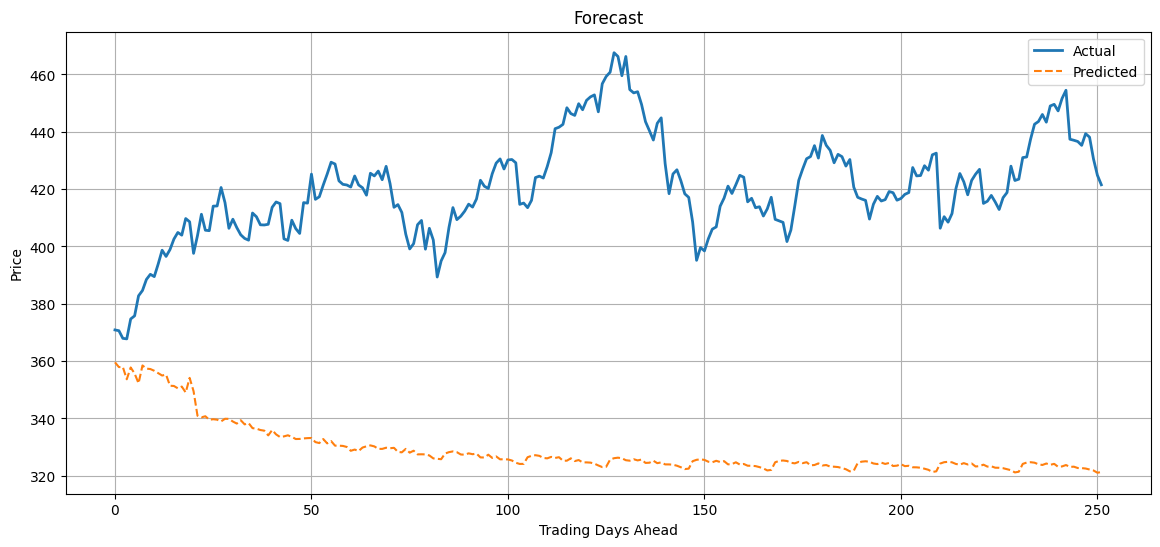

In [4]:
from testing_helpers import test_long_horizon, stats, plot

preds = test_long_horizon(
    model, X_test_t, scaler, TEST_DAYS, HORIZON
)

true = df[features].values[-TEST_DAYS:]

stats(true, preds)
plot(true, preds)